# Project Phase 2: Cats and Dogs Object Detection

# Project Abstract

The goal of this project is to create an end-to-end pipeline in machine learning to create an object detector for cats and dogs. In previous phases, we tested several machine learning models such as linear regression, SVM, and random forests and obtained an accuracy of 60.83% using the SVC model. In this phase, we implemented a homegrown classification and regression model, while also using PyTorch to try and further improve our results. We implemented 2 homegrown models, giving us a test CXE of 0.701 and a MSE of 0.245. We extended these models to use a loss function of CXE+MSE. We built separate PyTorch classification and regression model using MLP which gave us a validation accuracy of about 53%, and a validation MSE of 0.000257. We built a multi-head detector where we combined the CXE+MSE loss, giving us a validation accuracy of 58%. Our baseline PyTorch Pipeline model gives us 58.51%. Our CNN model run on the entire dataset gives a CXE+MSE loss of 0.843 and the best test accuracy of 70%. 


# Project Description

The purpose of this project is to create an end-to-end pipeline in machine learning to create an object detector for cats and dogs. There are about 13,000 images of varying shapes and aspect ratios. They are all RGB images and have bounding box coordinates stored in a .csv file. In order to create a detector, we will first have to preprocess the images to be all of the same shapes, take their RGB intensity values and flatten them from a 3D array to 2D. Then we will feed this array into a linear classifier and a linear regressor to predict labels and bounding boxes.

# Data Description

The image archive `cadod.tar.gz` is a subset [Open Images V6](https://storage.googleapis.com/openimages/web/download.html). The dataset to be used is a subset of Open Images Dataset V6. It contains a total of 12,993 images, which contains about 53% dog images and 47% cat images. Image bounding boxes are stored in the csv file `cadod.csv`. The bounding bex data indicate the position of the cat or dog in the image. This information includes the coordinates for the bounding boxes, the class of the image, and information on how the bounding boxes were made. It also contains various attributes about the image such as whether the image is occluded or truncated, or whether the image is a depiction of something or taken from inside an object.


The definitions of interested attributes:
* ImageID: the image this box lives in.
* Source: indicates how the box was made:
    * xclick are manually drawn boxes using the method presented in [1], were the annotators click on the four extreme points of the object. In V6 we release the actual 4 extreme points for all xclick boxes in train (13M), see below.
    * activemil are boxes produced using an enhanced version of the method [2]. These are human verified to be accurate at IoU>0.7.
* LabelName: the MID of the object class this box belongs to.
* Confidence: a dummy value, always 1.
* XMin, XMax, YMin, YMax: coordinates of the box, in normalized image coordinates. XMin is in [0,1], where 0 is the leftmost pixel, and 1 is the rightmost pixel in the image. Y coordinates go from the top pixel (0) to the bottom pixel (1).
* XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y: normalized image coordinates (as XMin, etc.) of the four extreme points of the object that produced the box using [1] in the case of xclick boxes. Dummy values of -1 in the case of activemil boxes.
* IsOccluded: Indicates that the object is occluded by another object in the image.
* IsTruncated: Indicates that the object extends beyond the boundary of the image.
* IsGroupOf: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
* IsDepiction: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
* IsInside: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).
For each of them, value 1 indicates present, 0 not present, and -1 unknown.

# Phase 2 tasks
* Homegrown cat/dog detector pipeline in Python and Numpy  
  * Implement a Homegrown Linear Regression model that has four target values. Extend the  MSE loss function from one target to four targets (x, y, w, h).
  * Implement a Homegrown Logistic Regression model. Extend the loss function from CXE to CXE + MSE, i.e., make it a complex multitask loss function where the resulting model predicts the class and bounding box coordinates at the same time
* PyTorch object detector pipeline 
  * Build a PyTorch model for image classification (using a multilayer perceptron (MLP))
  * Build another PyTorch model for regression  (using a multilayer perceptron (MLP)) with 4 target values [y_1, y_2, y_3, y_4] corresponding to [x, y, w, h] of the bounding box containing the object of interest).
  * Build a multi-headed cat-dog detector using the OOP API in PyTorch with a combined loss function: CXE + MSE.
* Build a convolutional neural network with multi-heads to do cat-dog detection [Stretch goal]
* Report
  * Report and short video presentation (2-minute video presentation; 300 words)
  * Post your presentation (video and slides) on the Canvas discussion board
* Each time selects 500 images where a  cat or dog is the main object in the image and labels the image accordingly and provides the tightest bounding box (rectangular box whose edges are parallel to the  X or Y axis)  that surrounds this main object.
* Build a baseline pipeline in PyTorch to do object classification and object localization (predict the bounding box that contains the main object of interest in the image).

# Import data, EDA and preprocessing

## Creat a custom dataset for PyTorch modeling

In [25]:
!pip install utils

In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision
import utils
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from torchvision.io import read_image
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

### Define CustomImageDataset function

In [27]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform, target_transform=None):
        self.samples = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        dog_label = '/m/0bt9lr'
        img_name = os.path.join(self.img_dir, self.samples.iloc[idx, 0]+'.jpg')
        image = Image.open(img_name).convert('RGB')
        if self.transform:
          image = self.transform(image)
        if self.samples.iloc[idx,2] == dog_label:
          label = torch.as_tensor(1, dtype=torch.int64)
        else:
          label = torch.as_tensor(0, dtype=torch.int64)
        img_id = torch.as_tensor(idx, dtype=torch.int64)
        box = torch.as_tensor([self.samples.iloc[idx, 4],
                               self.samples.iloc[idx, 6],
                               self.samples.iloc[idx, 5],
                               self.samples.iloc[idx, 7]], dtype=torch.float32)
        target = {}
        target['boxes'] = box
        target['labels'] = label
        target['image_id'] = img_id
        
        return image, target

### Transform data

In [28]:
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((128,128))
                                ])

annotations_file = '/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/cadod.csv'
img_dir = '/content/drive/MyDrive/AML 2021 Fall/CaDoD/images' 

dataset = CustomImageDataset(annotations_file=annotations_file, img_dir=img_dir, 
                             transform=transform, target_transform=None)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

### Plot images from trainloader

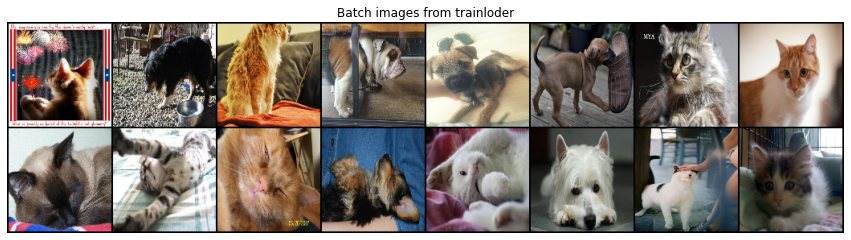

In [30]:
def plot_img(sample):
  image, target = sample
  grid = torchvision.utils.make_grid(image)
  plt.imshow(grid.numpy().transpose((1,2,0)))
  plt.title('Batch images from trainloder')

for images in trainloader:
  plt.figure(figsize=(15, 5))
  plot_img(images)
  plt.axis('off')
  plt.ioff()
  plt.show()
  break

## Generate the filtered dataset





In [ ]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
import tarfile
from tqdm.notebook import tqdm
import warnings

### Filter the bounding box dataset

In [ ]:
# Load bounding box dataset
df = pd.read_csv('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/cadod.csv')

# Select data by five important features: IsOccluded,	IsTruncated,	IsGroupOf,	IsDepiction,	IsInside.
df = df[df.IsTruncated==0]
df = df[df.IsOccluded==0]
df = df[df.IsDepiction==0]
df = df[df.IsGroupOf==0]
df = df[df.IsInside==0]

# Replace label name with cat/dog
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)
df

ImageID     Source LabelName  ...  XClick2Y  XClick3Y  XClick4Y
4      00064d23bf997652     xclick       dog  ...  0.370000  0.424286  0.694286
18     0020c297db8672b8     xclick       dog  ...  0.514620  0.903091  0.656642
49     0060b2fad4ef55d1     xclick       dog  ...  0.620000  0.158333  0.402500
80     009b71cc4fd38230     xclick       dog  ...  0.625263  0.300000  0.444211
127    0104ed24ce594848     xclick       dog  ...  0.960000  0.446250  0.597500
...                 ...        ...       ...  ...       ...       ...       ...
12945  ff3dd2b204a39a42     xclick       cat  ...  0.413125  0.100000  0.337500
12946  ff451d4fc378e028  activemil       cat  ... -1.000000 -1.000000 -1.000000
12953  ff9ceca28231f6fa  activemil       cat  ... -1.000000 -1.000000 -1.000000
12955  ffa777d9064123b1     xclick       cat  ...  0.447423  0.686598  0.668041
12960  ffc08e87dabfb85a     xclick       cat  ...  0.827500  0.663125  0.120000

[1348 rows x 21 columns]

In [ ]:
# Convert [XMin, YMin, XMax, YMax] to [x, y, w, h]
df['x'] = df['XMin']
df['y'] = df['YMin']
df['w'] = df['XMax'] - df['XMin']
df['h'] = df['YMax'] - df['YMin']
df

ImageID     Source LabelName  ...         y         w         h
4      00064d23bf997652     xclick       dog  ...  0.000000  0.665245  0.694286
18     0020c297db8672b8     xclick       dog  ...  0.233918  0.728750  0.669173
49     0060b2fad4ef55d1     xclick       dog  ...  0.158333  0.581250  0.752500
80     009b71cc4fd38230     xclick       dog  ...  0.300000  0.789628  0.638947
127    0104ed24ce594848     xclick       dog  ...  0.003750  0.907295  0.956250
...                 ...        ...       ...  ...       ...       ...       ...
12945  ff3dd2b204a39a42     xclick       cat  ...  0.100000  0.590057  0.899375
12946  ff451d4fc378e028  activemil       cat  ...  0.038917  0.434375  0.934856
12953  ff9ceca28231f6fa  activemil       cat  ...  0.122500  0.720000  0.780625
12955  ffa777d9064123b1     xclick       cat  ...  0.086598  0.921947  0.600000
12960  ffc08e87dabfb85a     xclick       cat  ...  0.120000  0.667954  0.736250

[1348 rows x 25 columns]

cat    952
dog    396
Name: LabelName, dtype: int64


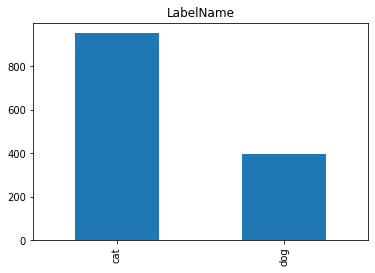

In [ ]:
# counts of images of different sources (indicates how the box was made)
print(df.LabelName.value_counts())

# plot counts
df.LabelName.value_counts().plot(kind='bar')
plt.title('LabelName')
plt.show()

Results:

1.   We filtered the data by five data features (IsOccluded, IsTruncated, IsGroupOf, IsDepiction, and	IsInside).
2.   After filtering, we obtained 1348 images. 952 of them are cats and 396 are dogs.



In [ ]:
# select dag and cat sub dataframe
dog_df = df.loc[df['LabelName'].isin(['dog'])]
cat_df = df.loc[df['LabelName'].isin(['cat'])]

# random select 396 cat data
cat_df_sample = cat_df.sample(n = 396)

# combine two df
df_sample = pd.concat([cat_df_sample, dog_df])
df_sample

ImageID     Source LabelName  ...         y         w         h
11779  c9a6b76a3203fae8     xclick       cat  ...  0.110000  0.573750  0.804167
7229   05a3d6cf8805b577     xclick       cat  ...  0.237500  0.767500  0.623333
9217   58a497360ceaeea2  activemil       cat  ...  0.021667  0.915178  0.930000
7484   1047c4b658ed794e     xclick       cat  ...  0.055000  0.680625  0.745833
9455   639037b0d91c3240     xclick       cat  ...  0.067227  0.804375  0.889822
...                 ...        ...       ...  ...       ...       ...       ...
6818   fe4a875f19122573     xclick       dog  ...  0.000000  0.856250  0.835189
6828   feb1e44ba1fb95c1     xclick       dog  ...  0.153912  0.688125  0.746598
6835   fef48f8da737704f     xclick       dog  ...  0.094229  0.831250  0.834186
6851   ffd53ce84d939909     xclick       dog  ...  0.363467  0.726875  0.573159
6854   fffa8a6573c894fe     xclick       dog  ...  0.039959  0.901367  0.920082

[792 rows x 25 columns]

### Re-scale images

In [ ]:
# rescale the filtered images
%%time
img_arr = np.zeros((df_sample.shape[0],128*128*3)) # initialize np.array

for i, f in enumerate(tqdm(df_sample.ImageID)):
    img = Image.open(path+f+'.jpg')
    img_resized = img.resize((128,128))
    img_resized.save("/content/drive/MyDrive/AML 2021 Fall/CaDoD/images/12_7_filtered_resized/"+f+'.jpg', "JPEG", optimize=True)
    img_arr[i] = np.asarray(img_resized, dtype=np.uint8).flatten()


  0%|          | 0/792 [00:00<?, ?it/s]

CPU times: user 5.34 s, sys: 308 ms, total: 5.65 s
Wall time: 33.6 s


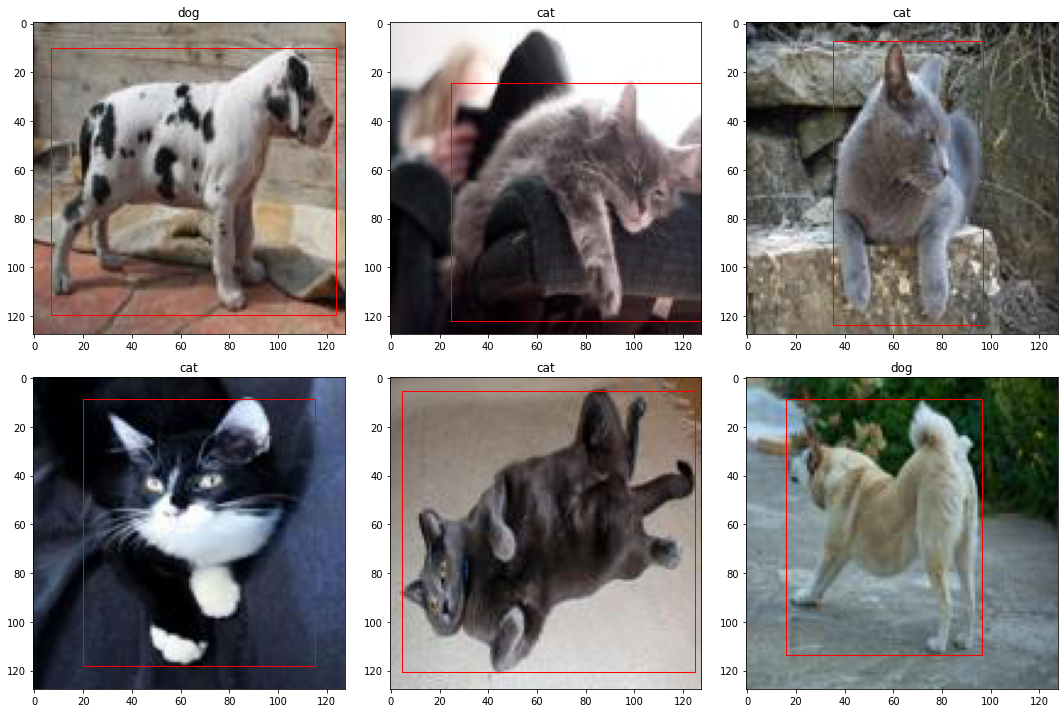

In [ ]:
# plot random 6 re-scaled images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(path+'filtered_resized/'+df.ImageID.values[j]+'.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[j,2])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

### Encode labels and save filtered dataset

In [ ]:
df = df_sample

# encode labels
df['Label'] = (df.LabelName == 'dog').astype(np.uint8)

# save filtered images
np.save('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img_filtered.npy', img_arr.astype(np.uint8))
np.save('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label_filtered.npy', df.Label.values)
np.save('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data//y_bbox_filtered.npy', df[['x', 'y', 'w', 'h']].values.astype(np.float32))

## Results


1.   By using CustomImageDataset function, we creat a custom dataset for PyTorch modeling.
2.   We select about 400 images for each dog and cat categories and save transformed data into numpy array.



# Homegrown cat/dog detector pipeline in Python and Numpy

* Implement a Homegrown Linear Regression model that has four target values. Extend the  MSE loss function from one target to four targets (x, y, w, h).
* Implement a Homegrown Logistic Regression model. Extend the loss function from CXE to CXE + MSE, i.e., make it a complex multitask loss function where the resulting model predicts the class and bounding box coordinates at the same time

## Homegrown linear regression model

### Import data

In [1]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from time import time
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
# Load whole data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Normalizing the input value [0, 1]
X = X.astype('float32')
X /= 255

# Convert [XMin,YMIN,XMAX,YMAX] to [x,y,w,h]
y_bbox[:,2] = y_bbox[:,2] - y_bbox[:,0] 
y_bbox[:,3] = y_bbox[:,3] - y_bbox[:,1] 

# Split the provided training data into training and validationa and test
X_train, X_test, y_train, y_test = train_test_split(X, y_bbox, train_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")

X train           shape: (8816, 49152)
X validation      shape: (2205, 49152)
X test            shape: (1945, 49152)


In [7]:
expLog = pd.DataFrame(columns=["exp_name",
                               "Train MSE",
                               "Valid MSE",
                               "Test  MSE"
                              ])

### Baseline linear regression model

In [8]:
from sklearn.linear_model import LinearRegression

with tf.device('/device:GPU:0'):
  exp_name = 'Baseline Linear Regression Model'

  lr_model = LinearRegression(n_jobs=-1)
  lr_model.fit(X_train, y_train)

  X_train_pred = lr_model.predict(X_train)
  X_test_pred = lr_model.predict(X_test)
  X_valid_pred = lr_model.predict(X_valid)

  expLog.loc[0,:] = [f"{exp_name}"] + list(np.round(
                [mean_squared_error(y_train, X_train_pred),
                  mean_squared_error(y_valid, X_valid_pred),
                  mean_squared_error(y_test, X_test_pred)],3))
  expLog

exp_name Train MSE Valid MSE Test  MSE
0  Baseline Linear Regression Model         0     0.044     0.048

### Homegrown linear regression model

In [11]:
class LinearRegressionHG:
    def __init__(self, X, Y):
        self.m = Y.size
        self.theta = np.zeros((X.shape[1], 1))

    def train(self, X, Y, learning_rate, iteration):
        
        for i in range(iteration):
            y_pred = np.dot(X, self.theta)
            cost = (1/(2*self.m)) * np.sum(np.square(y_pred - Y))

            d_theta = (1/self.m) * np.dot(X.T, y_pred - Y)
            self.theta = self.theta - learning_rate * d_theta

            if i % (iteration//10) == 0:
                print(f'Iteration {i} - Cost: {cost:.8f}')
                
    def predict(self, X):
        return np.dot(X, self.theta)

In [12]:
with tf.device('/device:GPU:0'):
  linreg = LinearRegressionHG(X_train, y_train)
  linreg.train(X_train, y_train, 0.0001, 100)

Iteration 0 - Cost: 0.18163427
Iteration 10 - Cost: 0.02168667
Iteration 20 - Cost: 0.02079337
Iteration 30 - Cost: 0.02054616
Iteration 40 - Cost: 0.02033441
Iteration 50 - Cost: 0.02015087
Iteration 60 - Cost: 0.01999135
Iteration 70 - Cost: 0.01985233
Iteration 80 - Cost: 0.01973080
Iteration 90 - Cost: 0.01962425


In [14]:
exp_name = 'Homegrown Linear Regression Model'

X_train_pred = linreg.predict(X_train)
X_test_pred = linreg.predict(X_test)
X_valid_pred = linreg.predict(X_valid)

expLog.loc[1,:] = [f"{exp_name}"] + list(np.round(
               [mean_squared_error(y_train, X_train_pred),
                mean_squared_error(y_valid, X_valid_pred),
                mean_squared_error(y_test, X_test_pred)],3))

expLog

exp_name Train MSE Valid MSE Test  MSE
0   Baseline Linear Regression Model         0     0.044     0.048
1  Homegrown Linear Regression Model     0.039      0.04      0.04

### results




1.   We generate a baseline linear regression model and a homegrown linear regression model for predicting four target values of bounding boxes.
2.   We found the homegrown linear regression model had a similar performance comparing to the baseline linear regression model (test MSE of homegrown model: 0.04; test MSE of baseline model: 0.048).



## Homegrown logistic regression model

### Import data

In [2]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
import tarfile
from tqdm.notebook import tqdm
import warnings

In [31]:
# Load whole data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Normalizing the input value [0, 1]
X = X.astype('float32')
X /= 255

# Convert [XMin,YMIN,XMAX,YMAX] to [x,y,w,h]
y_bbox[:,2] = y_bbox[:,2] - y_bbox[:,0] 
y_bbox[:,3] = y_bbox[:,3] - y_bbox[:,1] 

# Split the provided training data into training and validationa and test
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")

X train           shape: (8297, 49152)
X validation      shape: (2075, 49152)
X test            shape: (2594, 49152)


In [32]:
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train Acc",
                               "Test  Acc",
                               "Train CXE",
                               "Test  CXE",
                               "Train MSE",
                               "Test  MSE"
                              ])

### baseline logistic regression model

In [33]:
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def cross_entropy(y, h):
        return -np.mean(y * np.log(h+10**-10) + (1 - y) * np.log(1 - h + 10**-10))

with tf.device('/device:GPU:0'):
  model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=10000))])
  model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:, 1]

exp_name = f"Built-in Logistic Regression"
expLog.loc[0,:] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict_proba(X_train)[:, 1].round()), 
                accuracy_score(y_test_label, model.predict_proba(X_test)[:, 1].round()),
                cross_entropy(y_train, model.predict_proba(X_train)[:, 1]),
                cross_entropy(y_test_label, model.predict_proba(X_test)[:, 1]),
                mean_squared_error(y_train, model.predict_proba(X_train)[:, 1]),
                mean_squared_error(y_test_label, model.predict_proba(X_test)[:, 1])],3))


expLog

exp_name Train Acc  ... Train MSE Test  MSE
0  Built-in Logistic Regression         1  ...         0     0.439

[1 rows x 7 columns]

### Homegrown logistic regression with CXE loss function

In [34]:
class LogisticRegressionHG1:
    def __init__(self, X, learning_rate=0.0000001, num_iters=1000):
        self.lr = learning_rate
        self.num_iters = num_iters

        # m for #training_examples, n for #features
        self.m, self.n = X.shape

    def fit(self, X, y):
        
        y = np.reshape(y, (y.shape[0], 1))
        
        # init weights
        self.weights = np.zeros((self.n, 1))
        self.bias = 0

        for it in range(self.num_iters + 1):
            # calculate hypothesis
            y_predict = self.sigmoid(np.dot(X, self.weights) + self.bias)
#             print(y_predict.shape)

            # calculate cost
            cost = [(-1/ self.m * np.sum(y * np.log(y_predict + 10**-8) + (1 - y) * np.log(1 - y_predict + 10**-8))),
                    mean_squared_error(y, y_predict)]

            # back prop / gradient calculations using CXE loss
            dw = 1 / self.m * np.dot(X.T, (-y * np.log(y_predict + 10**-8) - (1 - y) * np.log(1 - y_predict + 10**-8)))
            db = 1 / self.m * np.sum(-y * np.log(y_predict + 10**-8) - (1 - y) * np.log(1 - y_predict + 10**-8))

            # gradient descent update step
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # print cost sometimes
            if it % 100 == 0:
                print(f"After iteration {it}:- Accuracy: {accuracy_score(y_predict>0.5, y):.3f}\t CXE: {cost[0]:.3f}\t MSE: {cost[1]:.3f}")

        return self.weights, self.bias

    def predict(self, X):
        y_predict = self.sigmoid(np.dot(X, self.weights) + self.bias)
        y_predict_labels = y_predict > 0.5

        return y_predict

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

In [35]:
model1 = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegressionHG1(X_train))])
w, b = model1.fit(X_train, y_train)

exp_name = "Homegrown Logistic Regression CXE"

X_train_pred = model1.predict(X_train)
X_test_pred = model1.predict(X_test)
expLog.loc[1,:] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, X_train_pred.round()), 
                accuracy_score(y_test, X_test_pred.round()),
                cross_entropy(y_train, X_train_pred),
                cross_entropy(y_test, X_test_pred),
                mean_squared_error(y_train, X_train_pred),
                mean_squared_error(y_test, X_test_pred)],3))

expLog

After iteration 0:- Accuracy: 0.474	 CXE: 0.693	 MSE: 0.250
After iteration 100:- Accuracy: 0.566	 CXE: 0.685	 MSE: 0.246
After iteration 200:- Accuracy: 0.576	 CXE: 0.682	 MSE: 0.244
After iteration 300:- Accuracy: 0.579	 CXE: 0.680	 MSE: 0.243
After iteration 400:- Accuracy: 0.583	 CXE: 0.678	 MSE: 0.243
After iteration 500:- Accuracy: 0.587	 CXE: 0.677	 MSE: 0.242
After iteration 600:- Accuracy: 0.588	 CXE: 0.676	 MSE: 0.241
After iteration 700:- Accuracy: 0.589	 CXE: 0.675	 MSE: 0.241
After iteration 800:- Accuracy: 0.590	 CXE: 0.674	 MSE: 0.240
After iteration 900:- Accuracy: 0.593	 CXE: 0.673	 MSE: 0.240
After iteration 1000:- Accuracy: 0.593	 CXE: 0.672	 MSE: 0.240


exp_name Train Acc  ... Train MSE Test  MSE
0       Built-in Logistic Regression         1  ...         0     0.439
1  Homegrown Logistic Regression CXE     0.593  ...      0.24     0.245

[2 rows x 7 columns]

### Homegrown logistic regression function with CXE+MSE loss function

In [36]:
class LogisticRegressionHG2:
    def __init__(self, X, learning_rate=0.0000002, num_iters=1000):
        self.lr = learning_rate
        self.num_iters = num_iters

        # m for #training_examples, n for #features
        self.m, self.n = X.shape

    def fit(self, X, y):
        
        y = np.reshape(y, (y.shape[0], 1))
        
        # init weights
        self.weights = np.zeros((self.n, 1))
        self.bias = 0

        for it in range(self.num_iters + 1):
            # calculate hypothesis
            y_predict = self.sigmoid(np.dot(X, self.weights) + self.bias)
#             print(y_predict.shape)

            # calculate cost
            cost = [(-1/ self.m * np.sum(y * np.log(y_predict + 10**-8) + (1 - y) * np.log(1 - y_predict + 10**-8))),
                    mean_squared_error(y, y_predict)]

            # back prop / gradient calculations using CXE loss + MSE loss
            dw = 1 / self.m * np.dot(X.T, (-y * np.log(y_predict + 10**-8) - (1 - y) * np.log(1 - y_predict + 10**-8) + np.sum(mean_squared_error(y, y_predict))))
            db = 1 / self.m * (np.sum(-y * np.log(y_predict + 10**-8) - (1 - y) * np.log(1 - y_predict + 10**-8) + mean_squared_error(y, y_predict)))

            # gradient descent update step
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # print cost sometimes
            if it % 100 == 0:
                print(f"After iteration {it}:- Accuracy: {accuracy_score(y_predict>0.5, y):.3f}\t CXE: {cost[0]:.3f}\t MSE: {cost[1]:.3f}")

        return self.weights, self.bias

    def predict(self, X):
        y_predict = self.sigmoid(np.dot(X, self.weights) + self.bias)
        y_predict_labels = y_predict > 0.5

        return y_predict

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

In [37]:
model2 = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegressionHG2(X_train))])
w, b = model2.fit(X_train, y_train)

exp_name = "Homegrown Logistic Regression CXE+MSE"

X_train_pred = model2.predict(X_train)
X_test_pred = model2.predict(X_test)
expLog.loc[2,:] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, X_train_pred.round()), 
                accuracy_score(y_test, X_test_pred.round()),
                cross_entropy(y_train, X_train_pred),
                cross_entropy(y_test, X_test_pred),
                mean_squared_error(y_train, X_train_pred),
                mean_squared_error(y_test, X_test_pred)],3))

expLog

After iteration 0:- Accuracy: 0.474	 CXE: 0.693	 MSE: 0.250
After iteration 100:- Accuracy: 0.576	 CXE: 0.682	 MSE: 0.244
After iteration 200:- Accuracy: 0.582	 CXE: 0.678	 MSE: 0.243
After iteration 300:- Accuracy: 0.588	 CXE: 0.676	 MSE: 0.241
After iteration 400:- Accuracy: 0.590	 CXE: 0.674	 MSE: 0.240
After iteration 500:- Accuracy: 0.593	 CXE: 0.672	 MSE: 0.240
After iteration 600:- Accuracy: 0.597	 CXE: 0.671	 MSE: 0.239
After iteration 700:- Accuracy: 0.600	 CXE: 0.669	 MSE: 0.238
After iteration 800:- Accuracy: 0.602	 CXE: 0.668	 MSE: 0.238
After iteration 900:- Accuracy: 0.604	 CXE: 0.667	 MSE: 0.237
After iteration 1000:- Accuracy: 0.608	 CXE: 0.666	 MSE: 0.237


exp_name Train Acc  ... Train MSE Test  MSE
0           Built-in Logistic Regression         1  ...         0     0.439
1      Homegrown Logistic Regression CXE     0.593  ...      0.24     0.245
2  Homegrown Logistic Regression CXE+MSE     0.608  ...     0.237     0.245

[3 rows x 7 columns]

### Plot images

In [ ]:
y_pred_label_proba = model2.predict(X_test)
y_pred_label_proba = np.reshape(y_test_label_proba, (y_test_label_proba.shape[0],))
y_pred_label = np.array([round(i) for i in y_test_label_proba])
y_pred_bbox = linreg.predict(X_test)

In [ ]:
y_test_label.shape

(12837,)

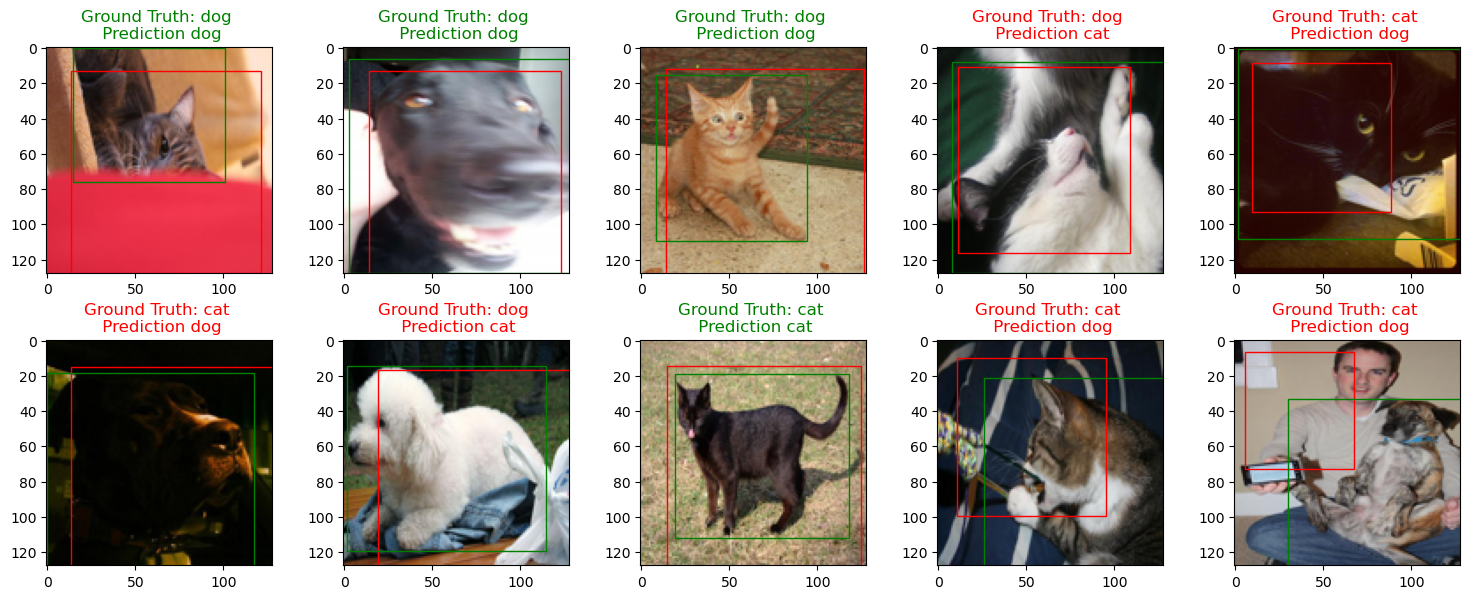

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False,figsize=(15,6))
ax = ax.flatten()

for i in range(10):
    img = X_test[i].reshape(128,128,3)
    coords = y_pred_bbox[i] * 128
    ax[i].imshow(img)
    ax[i].set_title('Ground Truth: {0} \n Prediction {1}'.format(idx_to_label[y_test_label[i]], idx_to_label[y_pred_label[i]]),
                   color=("green" if y_pred_label[i]==y_test_label[i] else "red"))
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='red', facecolor='none'))
    coords = y_test_bbox[i] * 128
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='green', facecolor='none'))

plt.tight_layout()
plt.show()

## Another Homegrown Logistic Model 

In [ ]:
# load data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder
print('X shape is        ', X.shape)
print('y_label shape is  ', y_label.shape)
print('y_bbox shape is   ', y_bbox.shape)

# Scaling X
X = X.astype(np.float32) / 255.0
y_label=y_label.astype(int)

# tain test split
np.random.seed(42)
subsample_rate = 0.5
X_train, _, y_train, _ = train_test_split(X, y_label, stratify=y_label, train_size=subsample_rate, random_state=42)
X_train, X_test, y_train, y_test_label  = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)
print(f"X train           shape: {X_train.shape}")
print(f"X test            shape: {X_test.shape}")

X shape is         (12966, 49152)
y_label shape is   (12966,)
y_bbox shape is    (12966, 4)
X train           shape: (5186, 49152)
X test            shape: (1297, 49152)


In [ ]:
class LogisticRegressionHomegrown(object):
    
    def __init__(self):
        """
        Constructor for the homgrown Logistic Regression
        
        Args:
            None
        
        Return:
            None
        """
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "acc": [], 
                        "val_cost":[], 
                        "val_acc": []}
        
    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        # number of training examples
        n = X.shape[0]
        
        # get scores for each class and example
        # 2D matrix
        scores = self._predict_raw(X)
        
        # transform scores to probabilities
        # softmax
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # error
        probs[range(n),y] -= 1
        
        # gradient
        gradient = np.dot(X.T, probs) / n
        
        return gradient
    
    def _gd(self, X, y, max_iter, alpha, X_val, y_val):
        """
        Runs Full GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        for i in range(max_iter):
            
            metrics = self.score(X, y)
            self.history["cost"].append(metrics["cost"])
            self.history["acc"].append(metrics["acc"])
            
            if X_val is not None:
                metrics_val = self.score(X_val, y_val)
                self.history["val_cost"].append(metrics_val["cost"])
                self.history["val_acc"].append(metrics_val["acc"])

            # calculate gradient
            grad = self._grad(X, y)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=1000, alpha=0.05, val_data=None):
        """
        Public API to fit Logistic regression model
        
        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        if val_data is not None:
            X_val, y_val = val_data
            X_val = np.c_[np.ones(X_val.shape[0]), X_val]
        else:
            X_val = None
            y_val = None
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1], len(np.unique(y)))
        
        # do full gradient descent
        self._gd(X, y, max_iter, alpha, X_val, y_val)
        
        # get final weigths and bias
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        
    def score(self, X, y):
        """
        Computes logloss and accuracy for (X, y)
        
        Args:
            X(ndarray):      objects
            y(ndarray):      answers for objects
            
        Return:
            metrics(dict):   python dictionary which
                             contains two fields: for accuracy 
                             and for objective function
        """
        # number of training samples
        n = X.shape[0]
        
        # get scores
        scores = self._predict_raw(X)
        
        # trasnform scores to probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # logloss per each example
        corect_logprobs = -np.log(probs[range(n),y])
        
        # total mean logloss
        data_loss = np.sum(corect_logprobs) / n
        
        # predictions
        pred = np.argmax(scores, axis=1)
        # accuracy
        acc = accuracy_score(y, pred)
        
        # final metrics
        metrics = {"acc": acc, "cost": data_loss}
        
        return metrics
        
    def _predict_raw(self, X):

        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            scores = np.dot(X, self._theta)
        else:
            scores = np.dot(X, self.coef_) + self.intercept_
        
        # normalize raw scores to prevent overflow
        scores -= np.max(scores, axis=1, keepdims=True)
        
        return scores

    def predict(self, X):
        """
        Predicts class for each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            pred(ndarray):   class for each object
        """
        # get scores for each class
        scores = self._predict_raw(X)
        # choose class with maximum score
        pred = np.argmax(scores, axis=1)
        return pred

In [ ]:
with tf.device('/device:GPU:0'):
  
  classifier_HG = LogisticRegressionHomegrown()
  classifier_HG.fit(X_train, y_train,  max_iter=1000, alpha=0.0001, val_data=(X_test, y_test_label))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
y_preds = classifier_HG.predict(X_test)
acc = accuracy_score(y_test_label, y_preds)
results = pd.DataFrame(columns=['Model','Accuracy'])

results.loc[len(results)] = ["classifier Homegrown", np.round(acc, 3)]
results

Model  Accuracy
0  classifier Homegrown     0.471

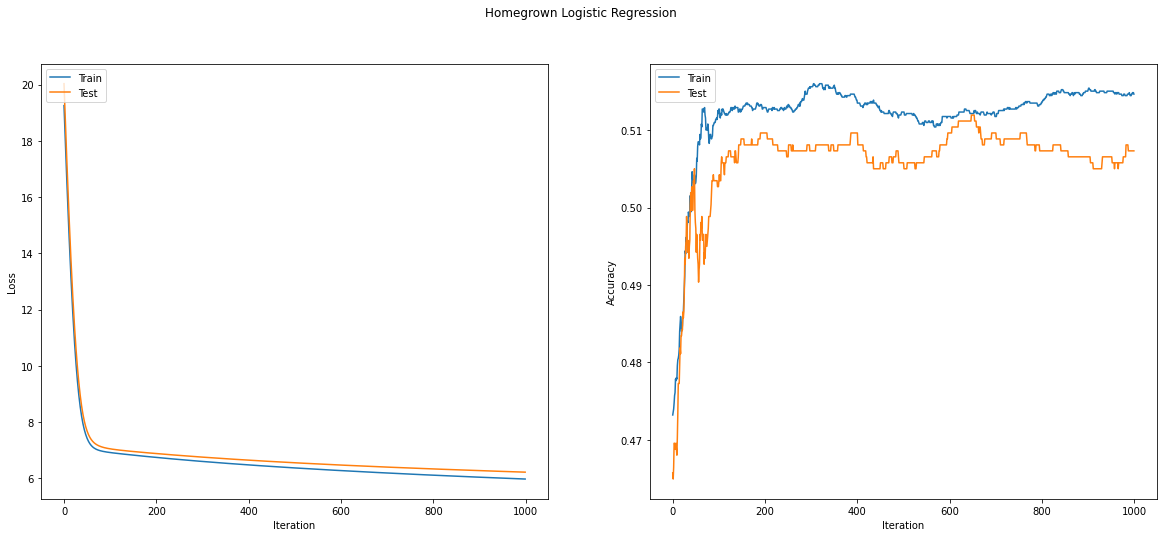

In [ ]:
plt.figure(figsize=(20, 8))
plt.suptitle("Homegrown Logistic Regression")
plt.subplot(121)
plt.plot(classifier_HG.history["cost"], label="Train")
plt.plot(classifier_HG.history["val_cost"], label="Test")
plt.legend(loc="upper left")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.subplot(122)
plt.plot(classifier_HG.history["acc"], label="Train")
plt.plot(classifier_HG.history["val_acc"], label="Test")
plt.legend(loc="upper left")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

### results

1. The homegrown logistic regression model gave an accuracy of 56.2% which is better than sklearn's logistic regression model.
2. Extending the loss function from CXE to CXE+MSE only provided a slight improvement. 

# PyTorch object detector pipeline--by using a multilayer perceptron (MLP)

* Build a PyTorch model for image classification (using a multilayer perceptron (MLP))
* Build another PyTorch model for regression  (using a multilayer perceptron (MLP)) with 4 target values [y_1, y_2, y_3, y_4] corresponding to [x, y, w, h] of the bounding box containing the object of interest).
* Build a multi-headed cat-dog detector using the OOP API in PyTorch with a combined loss function: CXE + MSE.

## PyTorch model for image classification

### Import data

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform, target_transform=None):
        self.samples = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        dog_label = '/m/0bt9lr'
        img_name = os.path.join(self.img_dir, self.samples.iloc[idx, 0]+'.jpg')
        image = Image.open(img_name).convert('RGB')
        if self.transform:
          image = self.transform(image)
        if self.samples.iloc[idx,2] == dog_label:
          label = torch.as_tensor(1, dtype=torch.int64)
        else:
          label = torch.as_tensor(0, dtype=torch.int64)
        
        return image, label

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((128,128))
                                ])
annotations_file = '/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/cadod.csv'
img_dir = '/content/drive/MyDrive/AML 2021 Fall/CaDoD/images' 

dataset = CustomImageDataset(annotations_file=annotations_file, img_dir=img_dir, transform=transform, target_transform=None)

In [6]:
train_set, test_set = torch.utils.data.random_split(dataset, [10373, 2593])
train_set, valid_set = torch.utils.data.random_split(train_set, [8298, 2075])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)

In [ ]:
def plot_img(sample):
  image, target = sample
  grid = torchvision.utils.make_grid(image)
  plt.imshow(grid.numpy().transpose((1,2,0)))

for images in trainloader:
  plt.figure(figsize=(15, 15))
  plot_img(images)
  plt.axis('off')
  plt.ioff()
  plt.title('Batch images from trainloder')
  plt.show()
  break

for images in testloader:
  plt.figure(figsize=(15, 15))
  plot_img(images)
  plt.axis('off')
  plt.title('Batch images from testloder')
  plt.ioff()
  plt.show()
  break

Output hidden; open in https://colab.research.google.com to view.

### Build the MLP classifier model

In [7]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Multilayer Perceptron Classifier
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(128 * 128 * 1, 32),
      nn.ReLU(),
      nn.Linear(32, 2),
    )

  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)


mlp_classifier = MLP()
mlp_classifier.to(device)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(mlp_classifier.parameters(), lr=1e-3)
#opt = optim.SGD(mlp_classifier.parameters(), lr=0.01, momentum=0.5)

In [12]:
loss_history = []
acc_history = []

def train_epoch(epoch, mlp_classifier, criterion, opt, trainloader, num_of_epochs, tag = "Train"):
    mlp_classifier.train() # set model in training mode (need this because of dropout)
    running_loss = 0
    overall_loss = 0
    correct = 0
    count = 0
    
    # dataset API gives us pythonic batching 
    for batch_id, data in enumerate(trainloader):
        inputs, target = data[0].to(device), data[1].to(device)        
        # 1:zero the grad, 2:forward pass, 3:calculate loss,  and 4:backprop!
        opt.zero_grad()
        preds = mlp_classifier(inputs) #prediction over the input data
        _, predicted_classes = torch.max(preds.data, 1)  # get the index of the max log-probability
        correct += (predicted_classes == target).sum().item()
        loss = criterion(preds, target)  #CXE loss for this batch
        loss_this_iter = loss.cpu().detach().numpy() # send loss value to CPU to save to logs
        overall_loss += (loss_this_iter * inputs.size(0))  # compute total loss to save to logs
        loss.backward() #calculate nabla_w
        loss_history.append(loss.item())
        opt.step()  #update W
        count += len(inputs)  #inputs.size(0)
                
        running_loss += loss.item()
        #print statistics
        if batch_id % 20 == 0:    # print every 20 mini-batches
          print(f"Epoch {epoch} of {num_of_epochs}, batch {batch_id+1}, batch loss: {np.round(loss.item(),6)}")
          running_loss = 0.0

    overall_loss /= float(count)
    accuracy = 100. * correct / count
    acc_history.append(accuracy)
    print(f"{tag} {epoch} set: {tag} loss: {overall_loss:.6f}, {tag} Acc: {correct}/{count} ({accuracy:.0f}%)")

    return mlp_classifier

def evaluate_model(epoch, mlp_classifier, criterion, opt, validloader, tag = "Test"):
    mlp_classifier.eval() # set model in inference mode (need this because of dropout)
    correct = 0
    count = 0
    overall_loss = 0.0

    for i,data in enumerate(validloader):
        inputs, targets = data[0].to(device), data[1].to(device)                
        outputs = mlp_classifier(inputs)
        # torch.max() Returns a namedtuple (values, indices) where values is the maximum value of each row of the 
        # input tensor in the given dimension dim. And indices is the index location of each maximum value found (argmax).
        _, predicted_classes = torch.max(outputs.data, 1)  # get the index of the max log-probability
        correct += (predicted_classes == targets).sum().item()        
        loss = criterion(outputs, targets)           # compute loss value
        loss_this_iter = loss.cpu().detach().numpy() # send loss value to CPU to save to logs
        overall_loss += (loss_this_iter * inputs.size(0))  # compute total loss to save to logs
        count += len(inputs)  #inputs.size(0)

        # compute mean loss
    overall_loss /= float(count)
    accuracy = 100. * correct / count
    acc_history.append(accuracy)
    print(f"{tag} {epoch} set: {tag} loss: {overall_loss:.6f}, {tag} Acc: {correct}/{count} ({accuracy:.0f}%)")
    print("-"*70)
    return accuracy

### Training and evaluation

In [ ]:
num_of_epochs = 5

for epoch in range(num_of_epochs):
    print("Epoch %d" % epoch)
    mlp_classifier = train_epoch(epoch, mlp_classifier, criterion, opt, trainloader, num_of_epochs, tag = "Train")
    evaluate_model(epoch,               mlp_classifier, criterion, opt, validloader, tag = "Valid")

evaluate_model(epoch, mlp_classifier, criterion, opt, testloader, tag="Test")

Epoch 0
Epoch 0 of 5, batch 1, batch loss: 0.688787
Epoch 0 of 5, batch 21, batch loss: 0.846031
Epoch 0 of 5, batch 41, batch loss: 0.713004
Epoch 0 of 5, batch 61, batch loss: 0.69936
Epoch 0 of 5, batch 81, batch loss: 0.713271
Epoch 0 of 5, batch 101, batch loss: 0.70622
Epoch 0 of 5, batch 121, batch loss: 0.70863
Train 0 set: Train loss: 0.723992, Train Acc: 4293/8298 (52%)
Valid 0 set: Valid loss: 0.688517, Valid Acc: 1128/2075 (54%)
----------------------------------------------------------------------
Epoch 1
Epoch 1 of 5, batch 1, batch loss: 0.688441
Epoch 1 of 5, batch 21, batch loss: 0.729417
Epoch 1 of 5, batch 41, batch loss: 0.689754
Epoch 1 of 5, batch 61, batch loss: 0.67095
Epoch 1 of 5, batch 81, batch loss: 0.688927
Epoch 1 of 5, batch 101, batch loss: 0.683201
Epoch 1 of 5, batch 121, batch loss: 0.683972
Train 1 set: Train loss: 0.691630, Train Acc: 4349/8298 (52%)
Valid 1 set: Valid loss: 0.691107, Valid Acc: 1119/2075 (54%)
-------------------------------------

52.64172772849981

## PyTorch model for regression 

### Import data

In [14]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform, target_transform=None):
        self.samples = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        dog_label = '/m/0bt9lr'
        img_name = os.path.join(self.img_dir, self.samples.iloc[idx, 0]+'.jpg')
        image = Image.open(img_name).convert('RGB')
        if self.transform:
          image = self.transform(image)
        if self.samples.iloc[idx,2] == dog_label:
          label = torch.as_tensor(1, dtype=torch.int64)
        else:
          label = torch.as_tensor(0, dtype=torch.int64)
        box = torch.as_tensor([self.samples.iloc[idx, 4],
                               self.samples.iloc[idx, 6],
                               self.samples.iloc[idx, 5]-self.samples.iloc[idx, 4],
                               self.samples.iloc[idx, 7]-self.samples.iloc[idx, 6]], dtype=torch.float32)
        
        return image, label, box

In [15]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((128,128))
                                ])
annotations_file = '/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/cadod.csv'
img_dir = '/content/drive/MyDrive/AML 2021 Fall/CaDoD/images' 

dataset = CustomImageDataset(annotations_file=annotations_file, img_dir=img_dir, transform=transform, target_transform=None)

In [16]:
train_set, test_set = torch.utils.data.random_split(dataset, [10373, 2593])
train_set, valid_set = torch.utils.data.random_split(train_set, [8298, 2075])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)

In [ ]:
def plot_img(sample):
  image, labels, boxes = sample
  grid = torchvision.utils.make_grid(image)
  plt.imshow(grid.numpy().transpose((1,2,0)))
  

for images in trainloader:
  plt.figure(figsize=(15, 15))
  plot_img(images)
  plt.axis('off')
  plt.ioff()
  plt.title('Batch images from trainloder')
  plt.show()
  break

for images in testloader:
  plt.figure(figsize=(15, 15))
  plot_img(images)
  plt.axis('off')
  plt.title('Batch images from testloder')
  plt.ioff()
  plt.show()
  break

Output hidden; open in https://colab.research.google.com to view.

### Build the MLP regression model

In [ ]:
import torch
from torchsummary import summary
from torch.autograd import Variable

for data in trainloader:
  x_train, y_labels_train, y_boxes_train = data[0], data[1], data[2] 

img_size = 128*128*1
m_rows, D_in, D_out, D_hidden = len(x_train), 128*128*1, 4, 100

# use the sequential API makes things simple
lr_model = torch.nn.Sequential( 
    nn.Flatten(),   
    torch.nn.Linear(D_in, D_hidden),   
    nn.ReLU(), #nn.Sigmoid()          
    torch.nn.Linear(D_hidden, D_hidden),   
    nn.ReLU(), #nn.Sigmoid()          
    nn.Linear(D_hidden, D_out)      
)

### Training and evaluation

In [ ]:

loss_fn = torch.nn.MSELoss(size_average=True)
learning_rate = 1e-3
optimizer = torch.optim.Adam(lr_model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(300):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred_boxes = lr_model(x_train)

    # Compute and print loss.
    loss = loss_fn(y_pred_boxes, y_boxes_train)
    if epoch % 10 == 0:
         print(f"Epoch:{epoch}, MSE: {loss.item():.9}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

print(lr_model)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch:0, MSE: 0.358011574
Epoch:10, MSE: 0.0613190569
Epoch:20, MSE: 0.0345063433
Epoch:30, MSE: 0.0216052216
Epoch:40, MSE: 0.0169420131
Epoch:50, MSE: 0.012845614
Epoch:60, MSE: 0.0104232803
Epoch:70, MSE: 0.00847368594
Epoch:80, MSE: 0.00688399747
Epoch:90, MSE: 0.00557202334
Epoch:100, MSE: 0.00447284197
Epoch:110, MSE: 0.0035997699
Epoch:120, MSE: 0.00414703367
Epoch:130, MSE: 0.00367732137
Epoch:140, MSE: 0.00215766393
Epoch:150, MSE: 0.00177117973
Epoch:160, MSE: 0.00130955304
Epoch:170, MSE: 0.000923316577
Epoch:180, MSE: 0.000733331137
Epoch:190, MSE: 0.00102667056
Epoch:200, MSE: 0.00275476812
Epoch:210, MSE: 0.00153858983
Epoch:220, MSE: 0.000397423195
Epoch:230, MSE: 0.000461430114
Epoch:240, MSE: 0.000296440499
Epoch:250, MSE: 0.000270076096
Epoch:260, MSE: 0.00288949418
Epoch:270, MSE: 0.00137430476
Epoch:280, MSE: 0.000765550532
Epoch:290, MSE: 0.000257316278
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=16384, out_features=100, bias=True)

## Multi-headed cat-dog detector

### Import data

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform, target_transform=None):
        self.samples = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        dog_label = '/m/0bt9lr'
        img_name = os.path.join(self.img_dir, self.samples.iloc[idx, 0]+'.jpg')
        image = Image.open(img_name).convert('RGB')
        if self.transform:
          image = self.transform(image)
        if self.samples.iloc[idx,2] == dog_label:
          label = torch.as_tensor(1, dtype=torch.int64)
        else:
          label = torch.as_tensor(0, dtype=torch.int64)
        box = torch.as_tensor([self.samples.iloc[idx, 4],
                               self.samples.iloc[idx, 6],
                               self.samples.iloc[idx, 5]-self.samples.iloc[idx, 4],
                               self.samples.iloc[idx, 7]-self.samples.iloc[idx, 6]], dtype=torch.float32)
        
        return image, label, box

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((128,128))
                                ])
annotations_file = '/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/cadod.csv'
img_dir = '/content/drive/MyDrive/AML 2021 Fall/CaDoD/images' 

dataset = CustomImageDataset(annotations_file=annotations_file, img_dir=img_dir, transform=transform, target_transform=None)

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [10373, 2593])
train_set, valid_set = torch.utils.data.random_split(train_set, [8298, 2075])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)

### Define model function

In [ ]:
class MultiHeadedDetector(nn.Module):

    def __init__(self):
        super(MultiHeadedDetector, self).__init__()
        self.fc1 = nn.Linear(128*128*1, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.output_labels = nn.Linear(256, 2)
        self.output_boxes = nn.Linear(256, 4)

    def forward(self, x):
        x = x.view(-1, 128*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        output_labels = self.output_labels(x)
        output_boxes = self.output_boxes(x)
        return output_labels, output_boxes


MultiHeadedDetector = MultiHeadedDetector()
MultiHeadedDetector.to(device)
print(MultiHeadedDetector)

MultiHeadedDetector(
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (output_labels): Linear(in_features=256, out_features=2, bias=True)
  (output_boxes): Linear(in_features=256, out_features=4, bias=True)
)


In [ ]:
for name, param in MultiHeadedDetector.named_parameters():
  print(name,'\t', param.shape)

fc1.weight 	 torch.Size([1024, 16384])
fc1.bias 	 torch.Size([1024])
fc2.weight 	 torch.Size([1024, 1024])
fc2.bias 	 torch.Size([1024])
fc3.weight 	 torch.Size([512, 1024])
fc3.bias 	 torch.Size([512])
fc4.weight 	 torch.Size([256, 512])
fc4.bias 	 torch.Size([256])
output_labels.weight 	 torch.Size([2, 256])
output_labels.bias 	 torch.Size([2])
output_boxes.weight 	 torch.Size([4, 256])
output_boxes.bias 	 torch.Size([4])


### Training and evaluation

In [ ]:
clf_criterion = torch.nn.CrossEntropyLoss()
lr_criterion = torch.nn.MSELoss()
opt = optim.Adam(MultiHeadedDetector.parameters(), lr=1e-3)

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
loss_history = []
acc_history = []

def train_epoch(epoch, MultiHeadedDetector, clf_criterion, lr_criterion, opt, trainloader, num_of_epochs, tag = "Train"):

    MultiHeadedDetector.train() # set model in training mode (need this because of dropout)
    running_loss = 0
    overall_loss = 0
    correct = 0
    count = 0
    
    # dataset API gives us pythonic batching 
    for batch_id, data in enumerate(trainloader):
        inputs, labels, boxes = data[0].to(device), data[1].to(device), data[2].to(device)       
        # 1:zero the grad, 2:forward pass, 3:calculate loss,  and 4:backprop!
        opt.zero_grad()
        preds = MultiHeadedDetector(inputs) #prediction over the input data
        #_, predicted_classes = torch.max(preds.data, 1)  # get the index of the max log-probability
        correct += get_num_correct(preds[0], labels)
        loss_clf = clf_criterion(preds[0], labels)  #CXE
        loss_lr = lr_criterion(preds[1], boxes)     #MSE
        loss = loss_clf + loss_lr                   #CXE+MSE
        loss_this_iter = loss.cpu().detach().numpy() # send loss value to CPU to save to logs
        overall_loss += (loss_this_iter * inputs.size(0))  # compute total loss to save to logs
        loss.backward() #calculate nabla_w
        loss_history.append(loss.item())
        opt.step()  #update W
        count += len(inputs)  #inputs.size(0)
                
        running_loss += loss.item()
        #print statistics
        if batch_id % 20 == 0:    # print every 20 mini-batches
          print(f"Epoch {epoch} of {num_of_epochs}, batch {batch_id+1}, batch loss: {np.round(loss.item(),6)}")
          running_loss = 0.0

    overall_loss /= float(count)
    accuracy = 100. * correct / count
    acc_history.append(accuracy)
    print(f"{tag} {epoch} set: {tag} loss: {overall_loss:.6f}, {tag} Acc: {correct}/{count} ({accuracy:.0f}%)")

    return MultiHeadedDetector

In [ ]:
def evaluate_model(epoch, MultiHeadedDetector,  clf_criterion, lr_criterion, opt, validloader, tag = "Test"):
    MultiHeadedDetector.eval() # set model in inference mode (need this because of dropout)
    running_loss = 0
    overall_loss = 0
    correct = 0
    count = 0

    for i,data in enumerate(validloader):
        inputs, labels, boxes = data[0].to(device), data[1].to(device), data[2].to(device)
        preds = MultiHeadedDetector(inputs) #prediction over the input data
        #_, predicted_classes = torch.max(preds.data, 1)  # get the index of the max log-probability
        #correct += (predicted_classes == target).sum().item()
        correct += get_num_correct(preds[0], labels)
        loss_clf = clf_criterion(preds[0], labels)
        loss_lr = lr_criterion(preds[1], boxes)
        loss = loss_clf + loss_lr
        loss_this_iter = loss.cpu().detach().numpy() # send loss value to CPU to save to logs
        overall_loss += (loss_this_iter * inputs.size(0))  # compute total loss to save to logs
        count += len(inputs)  

        # compute mean loss
    overall_loss /= float(count)
    accuracy = 100. * correct / count
    acc_history.append(accuracy)
    print(f"{tag} {epoch} set: {tag} loss: {overall_loss:.6f}, {tag} Acc: {correct}/{count} ({accuracy:.0f}%)")
    print("-"*70)
    return accuracy

In [ ]:
num_of_epochs = 5

for epoch in range(num_of_epochs):
    print("Epoch %d" % epoch)
    MultiHeadedDetector = train_epoch(epoch, MultiHeadedDetector, clf_criterion, lr_criterion, opt, trainloader, num_of_epochs, tag = "Train")
    evaluate_model(epoch,                    MultiHeadedDetector, clf_criterion, lr_criterion, opt, validloader, tag = "Valid")

evaluate_model(epoch, MultiHeadedDetector, clf_criterion, lr_criterion, opt, testloader, tag="Test")

Epoch 0
Epoch 0 of 5, batch 1, batch loss: 1.067986
Epoch 0 of 5, batch 21, batch loss: 0.747371
Epoch 0 of 5, batch 41, batch loss: 0.755609
Epoch 0 of 5, batch 61, batch loss: 0.744668
Epoch 0 of 5, batch 81, batch loss: 0.713516
Epoch 0 of 5, batch 101, batch loss: 0.727606
Epoch 0 of 5, batch 121, batch loss: 0.709619
Train 0 set: Train loss: 0.757003, Train Acc: 4330/8298 (52%)
Valid 0 set: Valid loss: 0.723358, Valid Acc: 1188/2075 (57%)
----------------------------------------------------------------------
Epoch 1
Epoch 1 of 5, batch 1, batch loss: 0.722813
Epoch 1 of 5, batch 21, batch loss: 0.736286
Epoch 1 of 5, batch 41, batch loss: 0.720833
Epoch 1 of 5, batch 61, batch loss: 0.721622
Epoch 1 of 5, batch 81, batch loss: 0.71049
Epoch 1 of 5, batch 101, batch loss: 0.716701
Epoch 1 of 5, batch 121, batch loss: 0.716715
Train 1 set: Train loss: 0.718808, Train Acc: 4530/8298 (55%)
Valid 1 set: Valid loss: 0.715394, Valid Acc: 1120/2075 (54%)
----------------------------------

56.6525260316236

## results



1.   We generated a MPL model for image classification, which has 53% test accuracy.
2.   We built another PyTorch model for regression, which has 0.0026 MSE loss.
3.   We build a multi-headed cat-dog detector using the OOP API in PyTorch with a combined loss function (CXE+MSE). This Model can predict both labels and bbox.Its test accuracy is 57% and the test loss is 0.70.



# Build a baseline pipeline in PyTorch to do object classification and object localization

## Import data

In [ ]:
# Load Data
X = np.load('drive/MyDrive/AML Project/data/img.npy', allow_pickle=True)
y_label = np.load('drive/MyDrive/AML Project/data/y_label.npy', allow_pickle=True)
y_bbox = np.load('drive/MyDrive/AML Project/data/y_bbox.npy', allow_pickle=True)

y_bounding = pd.DataFrame(columns=['x','y','w','h'])
y_bounding['x'] = df.XMin
y_bounding['y'] = df.YMin
y_bounding['w'] = df.XMax - df.XMin
y_bounding['h'] = df.YMax - df.YMin
y_bounding

y = np.concatenate((y_label.reshape(12966,-1), y_bounding), axis = 1)

# train validation test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Scaling
scaler = StandardScaler()
X_train =      scaler.fit_transform(X_train).astype(float)
X_validation = scaler.transform(X_validation).astype(float) #Transform valid set with the same constants
X_test =       scaler.transform(X_test).astype(float)       #Transform test  set with the same constants


# convert numpy arrays to tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_validation_tensor = torch.from_numpy(X_validation).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).float()
y_test_tensor = torch.from_numpy(y_test).float()
y_validation_tensor = torch.from_numpy(y_validation).float()

# create TensorDataset in PyTorch
train_ds = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
validation_ds = torch.utils.data.TensorDataset(X_validation_tensor, y_validation_tensor)
test_ds = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
# create dataloader
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(validation_ds, batch_size=X_test.shape[0], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=X_test.shape[0], shuffle=False, num_workers=0)

D_in = X_train.shape[1]

class MultiHeadMLP(nn.Module):

    def __init__(self, in_features):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 512)
        self.fc4 = torch.nn.Linear(512, 256)
        self.output_labels = nn.Linear(256, 1)
        self.output_boxes = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        labels = torch.sigmoid(self.output_labels(x))
        boxes = self.output_boxes(x)
        return torch.cat((labels, boxes), -1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(f"We are working on a {device} device")

class MultiHeadLoss(nn.Module):
    def __init__(self):
        super().__init__()
      
    def forward(self, y_pred, y):
        clf_loss = F.binary_cross_entropy(y_pred[:,0], y[:,0])
        reg_loss = F.mse_loss(y_pred[:,1:], y[:,1:])
        # print("Classification Loss: ",clf_loss)
        # print("Regression Loss: ",reg_loss)
        total_loss = clf_loss + reg_loss
        return total_loss



We are working on a cuda:0 device


## Define model pipelines

In [ ]:
class MultiHeadPipeline():
    def __init__(self, model, train_dataset, val_dataset = None):
        super(MultiHeadPipeline, self).__init__()
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        # self.test_dataset = test_dataset test_dataset = None

    def train(self, loss_fn, lr=1e-5, epochs = 6):
        self.train_acc = []
        self.train_loss = []

        opt = optim.Adam(self.model.parameters(), lr=1e-3)

        self.model.train() # set model in training mode (need this because of dropout)

        for epoch in range(epochs):
            print(f"Epoch {epoch+1}")
            running_loss = 0.0
            overall_loss = 0.0
            count = 0
            correct = 0

            # dataset API gives us pythonic batching 
            for batch_id, data in enumerate(self.train_dataset):
                inputs, target = data[0].to(device), data[1].to(device)        
                # 1:zero the grad, 2:forward pass, 3:calculate loss,  and 4:backprop!
                opt.zero_grad()
                preds = self.model(inputs) #prediction over the input data

                # print(preds[:,0].shape)
                # print(target.shape)
                predicted_classes = torch.round(preds[:,0])  # get the index of the max log-probability
                
                # compute loss and gradients
                loss = loss_fn(preds, target)

                loss.backward() #calculate nabla_w
                
                opt.step()  #update W
                
                running_loss += loss.item()
                count += inputs.size(0)
                correct += (predicted_classes == target[:, 0]).sum().item()

            self.train_loss.append(running_loss/len(self.train_dataset))
            self.train_acc.append(100. * correct/count)
        
            print(f"Epoch {epoch+1}, Train loss: {np.round(self.train_loss[-1],6)}, Train accuracy: {np.round(self.train_acc[-1], 2)}")

            if (self.val_dataset!=None):
                self.val_loss = []
                self.val_acc = []

                self.model.eval()
                val_running_loss = 0.0
                val_overall_loss = 0.0
                val_count = 0
                val_correct = 0

                # dataset API gives us pythonic batching 
                for batch_id, data in enumerate(self.val_dataset):
                    inputs, target = data[0].to(device), data[1].to(device)        
                    # 1:zero the grad, 2:forward pass, 3:calculate loss,  and 4:backprop!
                    
                    val_output = self.model(inputs) #prediction over the input data

                    predicted_classes = torch.round(val_output[:,0])  # get the index of the max log-probability
                    
                    # compute loss and gradients
                    loss = loss_fn(val_output, target)

                    val_running_loss += loss.item()
                    val_count += inputs.size(0)
                    val_correct += (predicted_classes == target[:, 0]).sum().item()

                self.val_loss.append(val_running_loss/len(self.val_dataset))
                self.val_acc.append(100. * val_correct/val_count)
            
                print(f"Epoch {epoch+1}, Validation loss: {np.round(self.val_loss[-1],6)}, Validation accuracy: {np.round(self.val_acc[-1], 2)}")

    def predict(self, test_dataset):
        self.model.eval()
        y_hat = []
        for batch_id, data in enumerate(test_dataset):
            inputs, target = data[0].to(device), data[1].to(device)
            test_output = self.model(inputs) # prediction over the input data
        
        return test_output


## Training and Evaluation

In [ ]:
# create classifier and optimizer objects
model = MultiHeadMLP(D_in)
model.to(device) # put on GPU before setting up the optimizer

pipeline = MultiHeadPipeline(model=model, train_dataset = train_loader, val_dataset = valid_loader)

pipeline.train(loss_fn = MultiHeadLoss(), lr = 1e-3, epochs = 6)

y_hat = pipeline.predict(test_dataset = test_loader)
y_hat_label = torch.round(y_hat[:,0])
y_hat_bounding = y_hat[:,1:]

accuracy = 0
for i in range(len(y_hat_label)):
    if y_hat_label[i].item() == y_test[:,0][i]:
        accuracy+=1
accuracy = 100*accuracy/len(y_test)

# accuracy = sum(([1 if y_test[:,0] == y_hat_label else 0]))
print("Accuracy on the test set labels: ", accuracy)

Epoch 1
Epoch 1, Train loss: 0.954531, Train accuracy: 53.18
Epoch 1, Validation loss: 0.73439, Validation accuracy: 54.41
Epoch 2
Epoch 2, Train loss: 0.727707, Train accuracy: 55.41
Epoch 2, Validation loss: 0.712612, Validation accuracy: 57.49
Epoch 3
Epoch 3, Train loss: 0.711046, Train accuracy: 58.02
Epoch 3, Validation loss: 0.718523, Validation accuracy: 57.88
Epoch 4
Epoch 4, Train loss: 0.69631, Train accuracy: 59.76
Epoch 4, Validation loss: 0.705905, Validation accuracy: 57.88
Epoch 5
Epoch 5, Train loss: 0.67525, Train accuracy: 62.07
Epoch 5, Validation loss: 0.707417, Validation accuracy: 56.19
Epoch 6
Epoch 6, Train loss: 0.654246, Train accuracy: 64.7
Epoch 6, Validation loss: 0.723917, Validation accuracy: 58.51
Accuracy on the test set labels:  59.4834232845027


# Convolutional neural networks with multi-heads to do cat-dog detection

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, BatchNormalization, Conv2D, MaxPool2D, Activation, MaxPooling2D, Dropout,AveragePooling2D, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import pandas as pd
from tensorflow.keras import initializers
from sklearn import decomposition
from keras import backend as K
import torch

import matplotlib.pyplot as plt
np.random.seed(42)

## Using whole dataset

### load whole dataset

In [2]:
# Load whole data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Normalizing the input value [0, 1]
# Reshape the input
X = X.astype('float32')
X /= 255
X = X.reshape(X.shape[0], 128,128,3)

# Convert [XMin,YMIN,XMAX,YMAX] to [x,y,w,h]
y_bbox[:,2] = y_bbox[:,2] - y_bbox[:,0] 
y_bbox[:,3] = y_bbox[:,3] - y_bbox[:,1] 

# Split the provided training data into training and validationa and test
X_train, X_test, y_label_train, y_label_test, y_bbox_train, y_bbox_test= train_test_split(X, y_label, y_bbox, test_size=0.2, random_state=42)

# Transform label indices to one-hot encoded vectors
num_classes = 2
y_label_train = to_categorical(y_label_train, num_classes)
y_label_test = to_categorical(y_label_test, num_classes)


### CNN model with label and box outupts

In [6]:
class MultiOutputCNN():

    def make_default_hidden_layers(self, inputs):

        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        return x

    def build_label_branch(self, inputs):

        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(2)(x)
        x = Activation("softmax", name="label_output")(x)
        return x

    def build_boxes_branch(self, inputs):   

        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(4)(x)
        x = Activation("linear", name="box_output")(x)
        return x

    def assemble_full_model(self):

        input_shape = (128,128,3)
        inputs = Input(shape=input_shape)
        label_branch = self.build_label_branch(inputs)
        box_branch = self.build_boxes_branch(inputs)
        model = Model(inputs=inputs,
                     outputs = [label_branch, box_branch],
                     name="CaDoD")
        return model
    
model = MultiOutputCNN().assemble_full_model()

In [7]:
# Train the model
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, 
              loss={'label_output': 'categorical_crossentropy', 'box_output': 'mse'},
              #loss_weights = {"label_output": 1.0, "box_output": 5.0},
              metrics={'label_output': 'accuracy', 'box_output': 'mse'})

# Model Fit
with tf.device('/device:GPU:0'):
  history = model.fit(x = X_train, y={'label_output': y_label_train,'box_output': y_bbox_train}, epochs=150, validation_split=0.2)

Epoch 1/150
260/260 [==============================] - 11s 23ms/step - loss: 2.1413 - label_output_loss: 0.9070 - box_output_loss: 1.2343 - label_output_accuracy: 0.5437 - box_output_mse: 1.2343 - val_loss: 4.0340 - val_label_output_loss: 3.2136 - val_box_output_loss: 0.8203 - val_label_output_accuracy: 0.4742 - val_box_output_mse: 0.8203
Epoch 2/150
260/260 [==============================] - 5s 20ms/step - loss: 0.9336 - label_output_loss: 0.6856 - box_output_loss: 0.2480 - label_output_accuracy: 0.5982 - box_output_mse: 0.2480 - val_loss: 10.5363 - val_label_output_loss: 1.3181 - val_box_output_loss: 9.2183 - val_label_output_accuracy: 0.5552 - val_box_output_mse: 9.2183
Epoch 3/150
260/260 [==============================] - 5s 20ms/step - loss: 0.7250 - label_output_loss: 0.6513 - box_output_loss: 0.0737 - label_output_accuracy: 0.6231 - box_output_mse: 0.0737 - val_loss: 3.1858 - val_label_output_loss: 0.9519 - val_box_output_loss: 2.2339 - val_label_output_accuracy: 0.6299 - val_b

### Evaluation and predictions

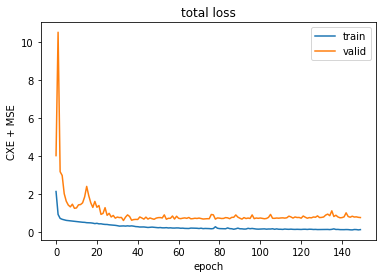

In [8]:
# total loss

# summarize history for total loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('total loss')
plt.ylabel('CXE + MSE')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

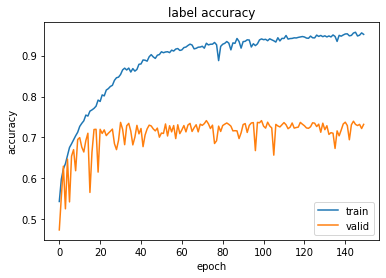

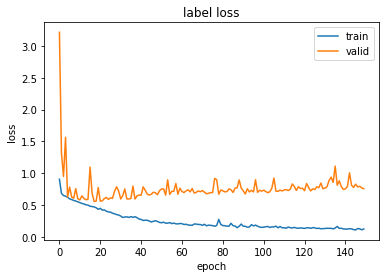

In [9]:
# loss and accuracy for label prediction

# summarize history for accuracy 
plt.plot(history.history['label_output_accuracy'])
plt.plot(history.history['val_label_output_accuracy'])
plt.title('label accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['label_output_loss'])
plt.plot(history.history['val_label_output_loss'])
plt.title('label loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

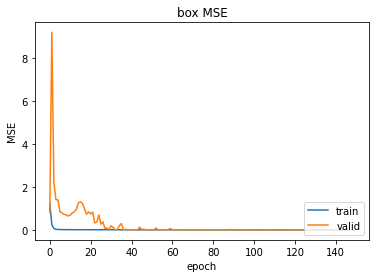

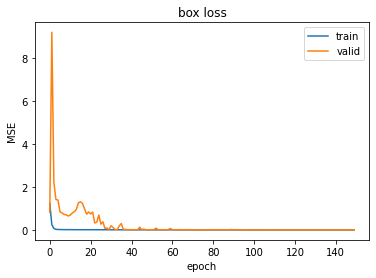

In [10]:
# MSE loss for box prediction

# summarize history for MSE 
plt.plot(history.history['box_output_mse'])
plt.plot(history.history['val_box_output_mse'])
plt.title('box MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['box_output_loss'])
plt.plot(history.history['val_box_output_loss'])
plt.title('box loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

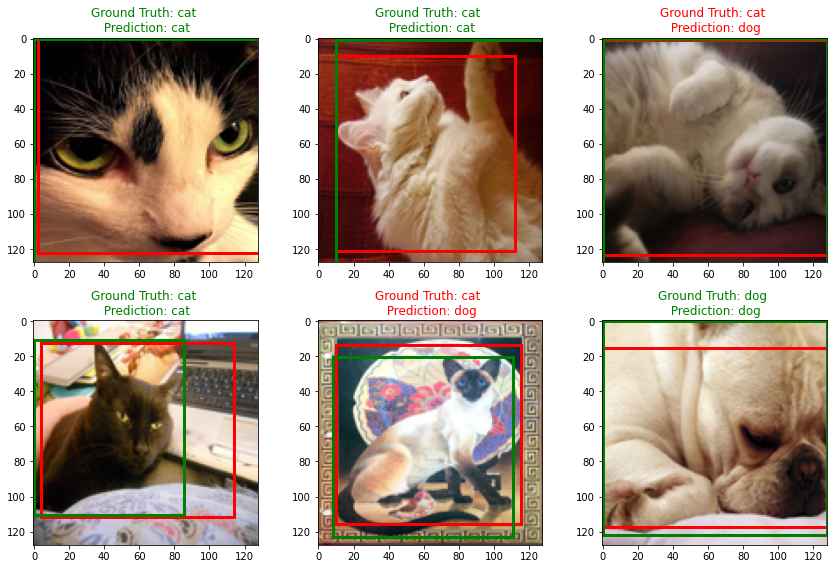

In [35]:
# Predict labels and bbox using CNN model
y_pred = model.predict(X_test)
y_pred_label = y_pred[0]
y_pred_bbox = y_pred[1]
y_pred_label = np.argmax(y_pred_label, axis=1)
y_label_test = np.argmax(y_label_test, axis=1)

# Plot 10 prediction results
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(12,8))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X_test.shape[0], size=6, replace=False)):
    img = X_test[j].reshape(128,128,3)
    coords = y_pred_bbox[j]*128
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1}".format(idx_to_label[y_label_test[j]],
                                                                   idx_to_label[y_pred_label[j]]),
                   color=("green" if y_pred_label[j]==y_label_test[j] else "red"))
    
    # print the predicted box in red
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2], coords[3], 
                                  edgecolor='red', facecolor='none', lw=3))
    

    # print the true box in green
    coords2 = y_bbox_test[j]*128
    
    ax[i].add_patch(plt.Rectangle((coords2[0], coords2[1]), 
                                  coords2[2], coords2[3], 
                                  edgecolor='green', facecolor='none', lw=3))

plt.tight_layout()
plt.show()

## Using filtered dataset

### load filtered dataset

In [36]:
# Load filtered data
X = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/img_filtered.npy', allow_pickle=True)
y_label = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_label_filtered.npy', allow_pickle=True)
y_bbox = np.load('/content/drive/MyDrive/AML 2021 Fall/CaDoD/data/y_bbox_filtered.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'} # encoder

# Normalizing the input value [0, 1]
# Reshape the input
X = X.astype('float32')
X /= 255
X = X.reshape(X.shape[0], 128,128,3)

# Split the provided training data into training and validationa and test
X_train, X_test, y_label_train, y_label_test, y_bbox_train, y_bbox_test= train_test_split(X, y_label, y_bbox, test_size=0.2, random_state=42)

# Transform label indices to one-hot encoded vectors
num_classes = 2
y_label_train = to_categorical(y_label_train, num_classes)
y_label_test = to_categorical(y_label_test, num_classes)

### CNN model with label and box outupts

In [42]:
class MultiOutputCNN():

    def make_default_hidden_layers(self, inputs):

        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        return x

    def build_label_branch(self, inputs):

        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(2)(x)
        x = Activation("softmax", name="label_output")(x)
        return x

    def build_boxes_branch(self, inputs):   

        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(4)(x)
        x = Activation("linear", name="box_output")(x)
        return x

    def assemble_full_model(self):

        input_shape = (128,128,3)
        inputs = Input(shape=input_shape)
        label_branch = self.build_label_branch(inputs)
        box_branch = self.build_boxes_branch(inputs)
        model = Model(inputs=inputs,
                     outputs = [label_branch, box_branch],
                     name="CaDoD")
        return model
    
model = MultiOutputCNN().assemble_full_model()

In [43]:
# Train the model
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, 
              loss={'label_output': 'categorical_crossentropy', 'box_output': 'mse'},
              #loss_weights = {"label_output": 1.0, "box_output": 5.0},
              metrics={'label_output': 'accuracy', 'box_output': 'mse'})

# Model Fit
with tf.device('/device:GPU:0'):
  history = model.fit(x = X_train, y={'label_output': y_label_train,'box_output': y_bbox_train}, epochs=150, validation_split=0.2)

Epoch 1/150
16/16 [==============================] - 2s 47ms/step - loss: 5.4129 - label_output_loss: 1.3781 - box_output_loss: 4.0347 - label_output_accuracy: 0.5138 - box_output_mse: 4.0347 - val_loss: 0.8787 - val_label_output_loss: 0.7010 - val_box_output_loss: 0.1778 - val_label_output_accuracy: 0.4882 - val_box_output_mse: 0.1778
Epoch 2/150
16/16 [==============================] - 0s 22ms/step - loss: 3.8272 - label_output_loss: 1.0152 - box_output_loss: 2.8121 - label_output_accuracy: 0.5968 - box_output_mse: 2.8121 - val_loss: 0.8309 - val_label_output_loss: 0.7148 - val_box_output_loss: 0.1161 - val_label_output_accuracy: 0.4409 - val_box_output_mse: 0.1161
Epoch 3/150
16/16 [==============================] - 0s 21ms/step - loss: 2.7884 - label_output_loss: 0.7872 - box_output_loss: 2.0012 - label_output_accuracy: 0.6462 - box_output_mse: 2.0012 - val_loss: 0.8680 - val_label_output_loss: 0.7045 - val_box_output_loss: 0.1635 - val_label_output_accuracy: 0.4961 - val_box_outpu

### Evaluation and predictions

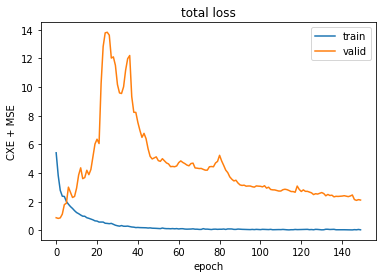

In [44]:
# total loss

# summarize history for total loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('total loss')
plt.ylabel('CXE + MSE')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

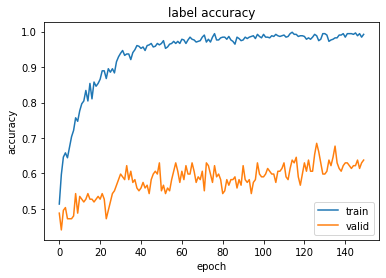

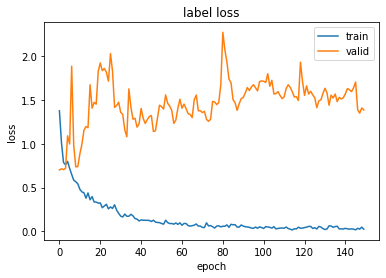

In [45]:
# loss and accuracy for label prediction

# summarize history for accuracy 
plt.plot(history.history['label_output_accuracy'])
plt.plot(history.history['val_label_output_accuracy'])
plt.title('label accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['label_output_loss'])
plt.plot(history.history['val_label_output_loss'])
plt.title('label loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

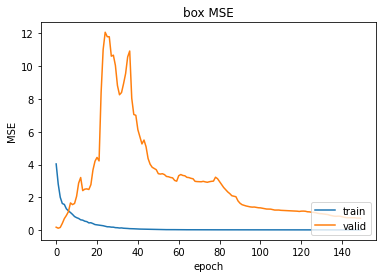

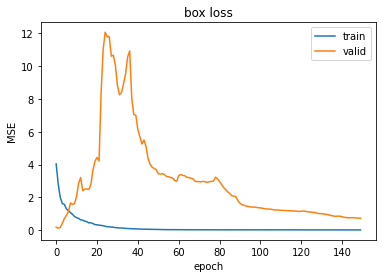

In [46]:
# MSE loss for box prediction

# summarize history for MSE 
plt.plot(history.history['box_output_mse'])
plt.plot(history.history['val_box_output_mse'])
plt.title('box MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['box_output_loss'])
plt.plot(history.history['val_box_output_loss'])
plt.title('box loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

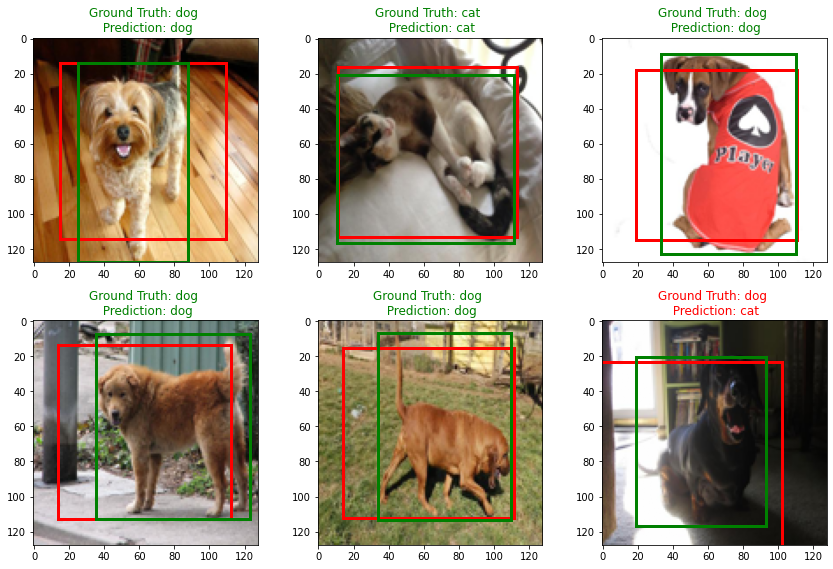

In [47]:
# Predict labels and bbox using CNN model
y_pred = model.predict(X_test)
y_pred_label = y_pred[0]
y_pred_bbox = y_pred[1]
y_pred_label = np.argmax(y_pred_label, axis=1)
y_label_test = np.argmax(y_label_test, axis=1)

# Plot 10 prediction results
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(12,8))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X_test.shape[0], size=6, replace=False)):
    img = X_test[j].reshape(128,128,3)
    coords = y_pred_bbox[j]*128
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1}".format(idx_to_label[y_label_test[j]],
                                                                   idx_to_label[y_pred_label[j]]),
                   color=("green" if y_pred_label[j]==y_label_test[j] else "red"))
    
    # print the predicted box in red
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2], coords[3], 
                                  edgecolor='red', facecolor='none', lw=3))
    

    # print the true box in green
    coords2 = y_bbox_test[j]*128
    
    ax[i].add_patch(plt.Rectangle((coords2[0], coords2[1]), 
                                  coords2[2], coords2[3], 
                                  edgecolor='green', facecolor='none', lw=3))

plt.tight_layout()
plt.show()

# Results and discussion

## Homegrown cat/dog detector pipeline in Python and Numpy

* We implemented a homegrown linear regression model using MSE loss function for predicting bounding boxes (MSE: 0.04)
* We implemented a homegrown logistic regression model using CXE and a custom loss function CXE + MSE (Test Acc: 56.4%)
* We combined their results and predicting classes and boxes on some test images.


## PyTorch object detector pipeline

* We built a multi-layer perceptron model for image classification which achieved an accuracy of 53%
* We built a multi-layer perception model for regression on bounding boxes
* We combined them and built a multi-headed cat/dog detector using the OOP api which achieved a test accuracy of 57%

## Convolutional neural network with multi-heads to do cat-dog detection

We built a multi-headed convolutional neural network to detect class as well as predict bounding boxes which achieved a class prediction loss of 0.0102, a bounding box prediction loss of 0.8333, and a total validation loss of 0.8435

## Discussion

In this phase, we generated different classification models with about 50-60% test accuracies. CNN model had the best test accuracy (70%). Previously, we can improve classification models by using the filtered dataset. However, this filtered dataset can not improve our CNN model. This may caused by the data size. This filtered dataset only have 900 images. In the future, we will use data augmentation to increase the dataset size to get better model training results.

Also, we need to performance more feature engineering methods to improve our models. Principal component analysis (PCA) is a technique for reducing the dimensionality of image datasets, increasing interpretability but at the same time minimizing information loss. We will try these methods to reduce the training time and to increase the accuracy.

# Conclusion and next steps


In Phase 2: 
* We generated two homegrown cat/dog detector pipelines a) Homegrown linear regression model – for bounding boxes b) Homegrown logistic regression model – for labels

* We built three PyTorch detector pipelines a) MLP model for image classification b) MLP model for regression c) multi-headed cat/dog detector using the OOP API

* We built a Convolutional neural network (CNN) model -- to predict both labels and bounding boxes




Next, we will do transfer learning for object detection and fine tuning using EfficientDet (D0-D7) for Cats and Dogs detection.

* Transform the cats and dogs training data (primarily the annotations data) so that EfficientDet can use them.
* Summarize the architecture and loss functions of EfficientDet
* Highlight the differences between EfficientDet D0 and EfficientDet D7